## Exploratory Data Analysis for Microsoft Film Studios

Authors: Alexander Claudino Daffara, Utku Kale

Blog post URLs: 

https://medium.com/@alexanderdaffara

https://medium.com/@utkukale


## Overview

Microsoft is launching a new film studio and using data analysis from sources like IMDb, The Numbers, and Kaggle to gain a deeper understanding of the film industry to maximize profits, visibility, and reception. The analysis will focus on identifying profitable genres, the impact of movie runtime, and the relationship between lead actor gender and box office success to inform their decision-making and strategy.

## Market and Business Understanding

Microsoft, a well-established tech company, is entering the film industry with the goal of creating successful and profitable films. It aims to ensure that its initial film releases are of the highest quality by analyzing film data from 2013-2019, which marks the beginning of the streaming services boom. The project will focus on key questions such as determining how much to spend on production to maximize profit, identifying profitable film genres and combinations of genres, and examining the impact of movie runtime, lead actor gender and how it affect profitability. 

By analyzing data from sources like IMDb, The Numbers, and Kaggle, the company aims to gain actionable insights that will inform their decision-making and strategy for the new film studio, thus increasing chances of a successful launch.

## Data

The Datasets we used are from imdb, The Numbers and Kaggle

IMDb data contains information about the movie GENRES and RUNTIME in minutes

146k movies before data-cleaning for our analysis
The Numbers contains information about PRODUCTION BUDGET and REVENUE for the films

~5.5k movies before data-cleaning for our analysis
Kaggle's "The Movie Dataset" contains information about cast and ACTOR GENDER

~45k movies before data-cleaning for our analysis

### Imports
Using sqlite3 and pandas for data analysis and cleaning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import warnings
warnings.filterwarnings(action='ignore')
%matplotlib inline

### imdb

In [17]:
conn = sqlite3.connect('data/im.db')
cursor = conn.cursor()
movie_basics_df = pd.read_sql("""SELECT * FROM movie_basics """, conn)    # 146144  movie_id  (unique)
conn.close()

# Contains information about movie release years, runtime and genres
print("Number of movies:", movie_basics_df.shape[0])
movie_basics_df.head()

Number of movies: 146144


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


### The Numbers movie budgets

In [20]:
budgets_df = pd.read_csv('data/tn.movie_budgets.csv')
budgets_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


### Budget data cleaning

In [21]:
# convert dates and prices from strings to numbers
budgets_df['production_budget'] = budgets_df['production_budget'].map(lambda x: x.replace('$','').replace(',','')).astype(int)
budgets_df['domestic_gross'] = budgets_df['domestic_gross'].map(lambda x: x.replace('$','').replace(',','')).astype(int)
budgets_df['worldwide_gross'] = budgets_df['worldwide_gross'].map(lambda x: x.replace('$','').replace(',','')).astype('int64')

# release_year calculated from release date
budgets_df['release_year'] = budgets_df['release_date'].map(lambda x: int(x[-4:]))
# foreign gross column calculated from total gross and domestic gross
budgets_df['foreign gross'] = budgets_df['worldwide_gross'] - budgets_df['domestic_gross']
# profit column calculated from total gross and production budgets
budgets_df['profit'] = budgets_df['worldwide_gross'] - budgets_df['production_budget']

# drop unnecessary columns
budgets_df.drop(columns=['id', 'release_date'], inplace=True)

# drop rows with no worldwide gross
budgets_df = budgets_df.loc[budgets_df['worldwide_gross'] != 0]

# CONSIDER ONLY movies released AFTER 2013
budgets_df = budgets_df.loc[budgets_df['release_year'] >= 2013]

# modern_budgets_df_reset is used to reset modern_budgets_df when it is modified through the Analysis
modern_budgets_df_reset = budgets_df.loc[budgets_df['release_year'] >= 2013]
modern_budgets_df = modern_budgets_df_reset.copy()

# contains cleaned data on production budgets, profit, and release_year (only films after 2013)
print("Number of movies:", modern_budgets_df.shape[0])
modern_budgets_df.head()

Number of movies: 1216


,movie,production_budget,domestic_gross,worldwide_gross,release_year,foreign gross,profit
2,Dark Phoenix,350000000,42762350,149762350,2019,107000000,-200237650
3,Avengers: Age of Ultron,330600000,459005868,1403013963,2015,944008095,1072413963
4,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017,696540365,999721747
5,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,2015,1116648995,1747311220
6,Avengers: Infinity War,300000000,678815482,2048134200,2018,1369318718,1748134200


### Removing profit outliers

In [22]:
# THIS WILL SET MODERN BUDGETS TO EXCLUDE 150/1216 PROFIT OUTLIERS
modern_budgets_df = modern_budgets_df_reset.copy() # 1216 x 8
iqr = modern_budgets_df['profit'].quantile(.75) - modern_budgets_df['profit'].quantile(.25)
upper_bound = modern_budgets_df.profit.mean() + 1.5 * iqr
lower_bound = modern_budgets_df.profit.mean() - 1.5 * iqr
modern_budgets_df = modern_budgets_df.loc[(modern_budgets_df.profit < upper_bound) & \
                                          (modern_budgets_df.profit > lower_bound)]

# Contains information about movie release years, runtime and genres
print("Number of movies:", modern_budgets_df.shape[0])
modern_budgets_df.head()

Number of movies: 1063


,movie,production_budget,domestic_gross,worldwide_gross,release_year,foreign gross,profit
11,Solo: A Star Wars Story,275000000,213767512,393151347,2018,179383835,118151347
12,The Lone Ranger,275000000,89302115,260002115,2013,170700000,-14997885
64,The Mummy,195000000,80101125,409953905,2017,329852780,214953905
65,Jack the Giant Slayer,195000000,65187603,197687603,2013,132500000,2687603
69,The Great Gatsby,190000000,144840419,351040419,2013,206200000,161040419


# Insight 1: 
### Spend More to earn more. Risk of loss is reduced especially above 50 million in production budget.



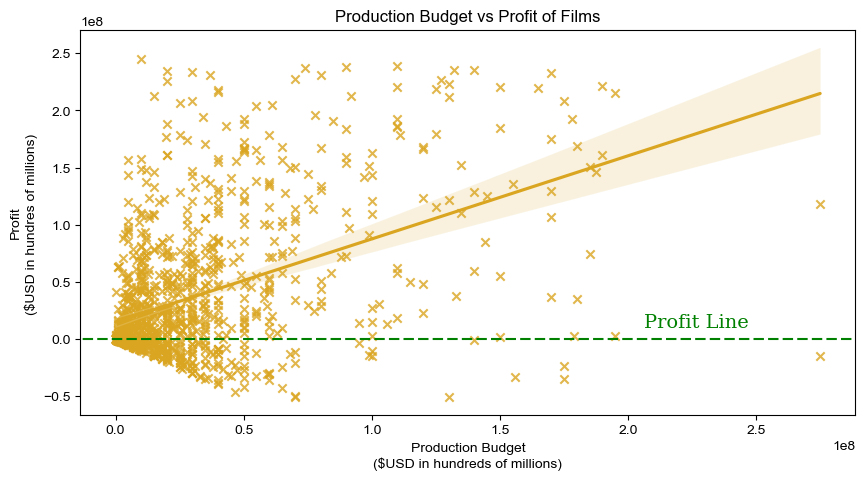

0.7777708411019403

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
sns.set_style('darkgrid')
sns.regplot(x='production_budget',
            y='profit',
            data=modern_budgets_df,
            scatter=True,
            color='goldenrod',
            marker='x',
            ax=ax)

plt.plot(range(0,-50000000))
plt.axhline(0,modern_budgets_df.production_budget.max(),0, color='green', dashes=[5,2])


ax.text(modern_budgets_df.production_budget.max()*.75,10000000,'Profit Line', fontdict={'family': 'serif',
                                                                                        'color':  'Green',
                                                                                        'weight': 'normal',
                                                                                        'size': 14,
                                                                                        })

ax.set_xlabel('Production Budget\n($USD in hundreds of millions)')
ax.set_ylabel('Profit\n($USD in hundres of millions) ')
ax.set(title='Production Budget vs Profit of Films')
plt.show()
print("Pearson Correlation:", modern_budgets_df.corr()['production_budget']['worldwide_gross'])

# Genre vs profit

MULTI-Genre grouping

In [8]:
# profit_genreTuples_df has genres tuples for each film split (exploded) into multiple rows
genreTuples_df = movie_basics_df.dropna(subset=['genres'])[['movie_id',
                                                            'primary_title',
                                                            'start_year',
                                                            'genres']]
genreTuples_df['genres'] = genreTuples_df['genres'].map(lambda x: tuple(x.split(',')))
profit_genreTuples_df = modern_budgets_df.merge(genreTuples_df,
                                                how='inner',
                                                left_on=['movie',
                                                         'release_year'],
                                                right_on=['primary_title', 
                                                          'start_year'])[['movie',
                                                                          'release_year',
                                                                          'profit',
                                                                          'genres']]
# FOR CONCATENATED VERSION
exploded = profit_genreTuples_df.explode('genres')

# ONLY EXPLODING 3-GRAMS INTO 2-GRAMS
for i in profit_genreTuples_df.index:
    row = profit_genreTuples_df.iloc[i]
        
    genres = row['genres']
    if len(genres) == 3:
        new_row = {col:row[col] for col in row.index.to_list()}

        # genres[0,1]
        new_row['genres'] = (genres[0],genres[1])
        profit_genreTuples_df = profit_genreTuples_df.append(new_row, ignore_index=True)
        
        # genres[0,2]
        new_row['genres'] = (genres[0],genres[2])
        profit_genreTuples_df = profit_genreTuples_df.append(new_row, ignore_index=True)
        
        # genres[1,2]
        new_row['genres'] = (genres[1],genres[2])
        profit_genreTuples_df = profit_genreTuples_df.append(new_row, ignore_index=True)


# REMOVING 3-GRAMS
def keep_3_grams(keep, x):
    if keep:
        return len(x) >= 2
    else:
        return len(x) == 2

three_or_two_grams = \
    profit_genreTuples_df.loc[profit_genreTuples_df['genres'].map(lambda x: \
                                                                  True if keep_3_grams(True,x) else False)]

# for some reason exploded has duplicates
profit_genreTuples_df = pd.concat([three_or_two_grams,exploded]).drop_duplicates()
profit_genreTuples_df

,movie,release_year,profit,genres
0,Solo: A Star Wars Story,2018,118151347,"(Action, Adventure, Fantasy)"
1,The Lone Ranger,2013,-14997885,"(Action, Adventure, Western)"
2,The Mummy,2017,214953905,"(Action, Adventure, Fantasy)"
3,Jack the Giant Slayer,2013,2687603,"(Adventure, Fantasy)"
4,The Great Gatsby,2013,161040419,"(Drama, Romance)"
...,...,...,...,...
786,Counting,2015,-41626,Documentary
787,Emily,2017,-23453,Drama
788,Exeter,2015,464792,Horror
788,Exeter,2015,464792,Mystery


In [9]:
""" FOR LABELLING GENRE PLOT"""
def get_pretty_labels(ugly):
    labels = []
    for genre in ugly:
        if type(genre) == tuple:
            if len(genre) == 3:
                labels.append('{}, {} & {}'.format(genre[0],genre[1],genre[2]))
            if len(genre) == 2:
                labels.append('{} & {}'.format(genre[0],genre[1]))
        else:
            labels.append(genre)
    return labels

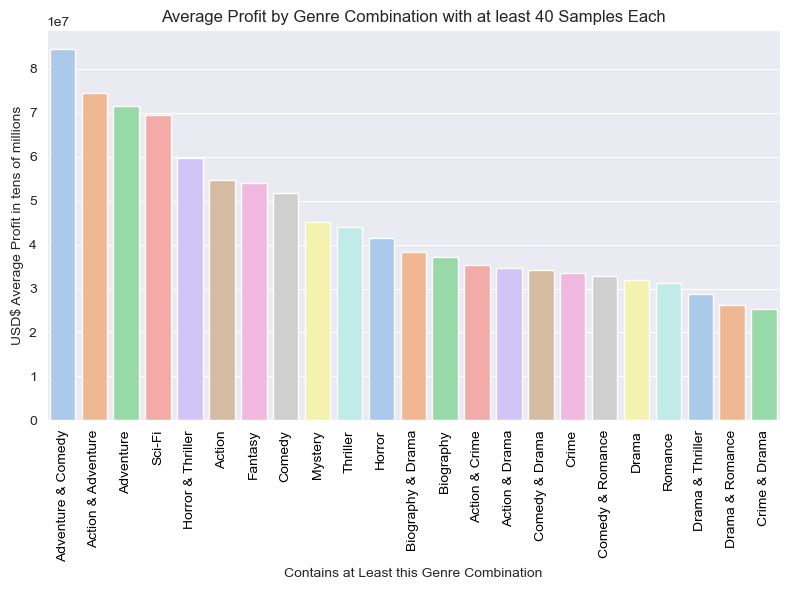

In [10]:
# DATA FOR PROFIT PER GENRETUPLES WITH AT LEAST n SAMPLES EACH
num_samples_per_genre_tuple = 40

# reset grouped_tuples so its not just the top 20
grouped_tuples_df = profit_genreTuples_df.groupby('genres').mean().sort_values(by='profit', ascending=False)

# grouped_tuple_count_df has 129 unique genre-combo movies and single-genre movies (29 with over 30 samples)
grouped_tuple_count_df = profit_genreTuples_df.groupby('genres').count()
grouped_tuple_count_df = grouped_tuple_count_df.loc[grouped_tuple_count_df['profit'] > num_samples_per_genre_tuple]
tuple_profit_30samples_df = grouped_tuples_df.join(grouped_tuple_count_df, how='inner', rsuffix='_count').sort_values(by='profit', ascending=False)

fig, ax = plt.subplots(figsize=(8,6))

xlabels = get_pretty_labels(tuple_profit_30samples_df.index)
data = tuple_profit_30samples_df
ax = sns.barplot(x=data.index,
            y='profit',
            data=data,
            errwidth=0,
            palette='pastel',
            ax=ax)

ax.set_title('Average Profit by Genre Combination with at least {} Samples Each'.format(num_samples_per_genre_tuple))
ax.set_xlabel('Contains at Least this Genre Combination')
ax.set_ylabel('USD$ Average Profit in tens of millions')
ax.set_xticklabels(xlabels, rotation=90, color='black')
fig.tight_layout()
plt.show()


Top 1 Genre Highlighted Cost v Profit

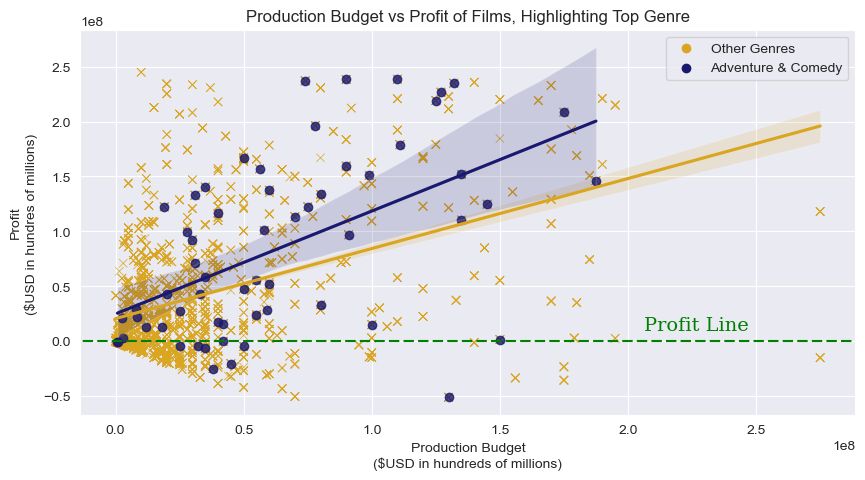

In [11]:
""" cost_v_profit_df has ['movie','release_year','genres' (optimized),'production_budget','profit'] """

cost_v_profit_df = profit_genreTuples_df.merge(modern_budgets_df[['movie','release_year','production_budget']],
                                               how='inner',
                                               left_on=['movie', 'release_year'],
                                               right_on=['movie','release_year'],
                                               suffixes=['_',''])

top_genre = [('Adventure', 'Comedy')]
top_loc = cost_v_profit_df['genres'].map(lambda x: True if x in top_genre else False)
cost_v_profit_df['is_top_genre'] = top_loc.map(lambda x: 'Adventure & Comedy' if x else 'Other Genres')

fig, ax = plt.subplots(figsize=(10,5))

# sns.regplot(x='production_budget',
#             y='profit',
#             data=modern_budgets_df,
#             scatter=True,
#             color='goldenrod',
#             marker='x',
#             ax=ax)
data = cost_v_profit_df
sns.scatterplot(x='production_budget',
                y='profit',
                hue='is_top_genre',
                legend='auto',
                data=data,
                palette=['goldenrod','midnightblue'],
                marker='x',
                ax=ax)

data = cost_v_profit_df.loc[~top_loc]
sns.regplot(x='production_budget',
            y='profit',
            scatter=False,
            color='goldenrod',
            data=data,
            ax=ax)

data = cost_v_profit_df.loc[top_loc]
sns.regplot(x='production_budget',
            y='profit',
            scatter=True,
            color='midnightblue',
            data=data,
            ax=ax)

# plotting reference lines and text
plt.plot(range(0,-50000000))
plt.axhline(0,modern_budgets_df.production_budget.max(),0, color='green', dashes=[5,2])

ax.text(modern_budgets_df.production_budget.max()*.75,10000000,'Profit Line', fontdict={'family': 'serif',
                                                                                        'color':  'Green',
                                                                                        'weight': 'normal',
                                                                                        'size': 14,
                                                                                        })

ax.set_xlabel('Production Budget\n($USD in hundreds of millions)')
ax.set_ylabel('Profit\n($USD in hundres of millions) ')
ax.set(title='Production Budget vs Profit of Films, Highlighting Top Genre')
sns.set_style('dark')
ax.legend(title='')
plt.show()

# Profit vs runtime

In [12]:
# CONSIDER IMPUTING MEAN/MEDIAN for 31k out of 146k 
runtime_df = movie_basics_df.dropna(subset=['runtime_minutes'])
runtime_df = runtime_df.loc[runtime_df['runtime_minutes'] < 200]
profit_runtime_df = modern_budgets_df.merge(runtime_df[['primary_title','start_year','runtime_minutes']],
                                            how='inner',
                                            left_on=['movie','release_year'],
                                            right_on=['primary_title','start_year'])
def get_length(x):
    short_bound = profit_runtime_df['runtime_minutes'].quantile(.33)
    long_bound = profit_runtime_df['runtime_minutes'].quantile(.66)
    if x < short_bound:
        return 'short'
    if x < long_bound:
        return 'medium'
    else:
        return 'long'
    

profit_runtime_df['length'] = profit_runtime_df['runtime_minutes'].map(get_length)

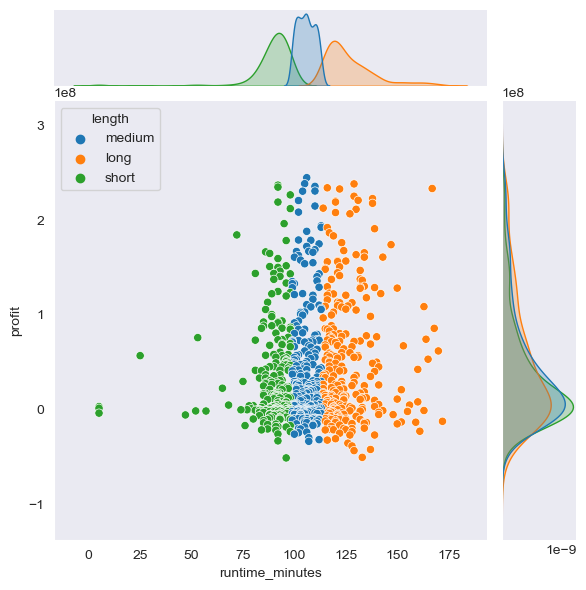

average movie runtimes per category: 
length
long      126.888060
medium    105.625468
short      88.879032
Name: runtime_minutes, dtype: float64

length value counts:
long      268
medium    267
short     248
Name: length, dtype: int64

average short profit: 33,817,284
average medium profit: 42,747,487
average long profit: 52,570,746


In [13]:
# look at runtime vs profit for the top_n highest profit films 
top_n = 783
# int(np.floor(783*.2)) # max n = 783

most_profit_df = profit_runtime_df.sort_values(by='profit', ascending=False).head(top_n)
sns.jointplot(x='runtime_minutes',
              y='profit',
              hue='length',
              data=most_profit_df,
              kind='scatter')

plt.show()
print("average movie runtimes per category: ")
print(most_profit_df.groupby('length').mean()['runtime_minutes'], end='\n\n')
print("length value counts:")
print(most_profit_df['length'].value_counts(), end='\n\n')
print("average short profit: {:,}".format(int(profit_runtime_df.loc[profit_runtime_df['length'] == 'short']['profit'].mean())))
print("average medium profit: {:,}".format(int(profit_runtime_df.loc[profit_runtime_df['length'] == 'medium']['profit'].mean())))
print("average long profit: {:,}".format(int(profit_runtime_df.loc[profit_runtime_df['length'] == 'long']['profit'].mean())))

### Runtime Distribution per top 5 Genres

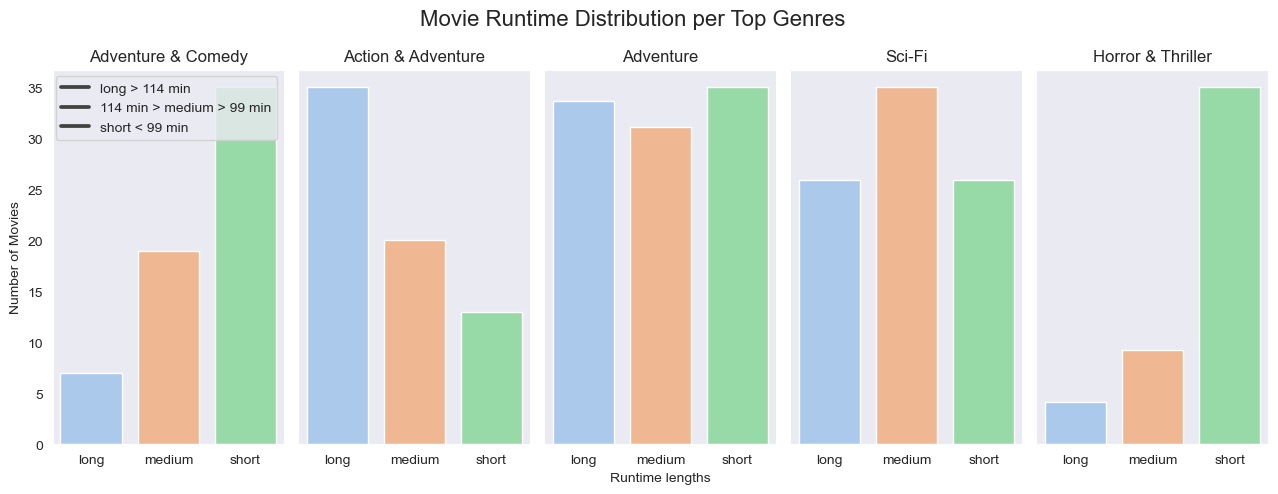

In [104]:
top5_genre_combos = [('Adventure', 'Comedy'),('Action', 'Adventure'),'Adventure','Sci-Fi',('Horror', 'Thriller')]
most_profit_truncated_df = most_profit_df[['movie','release_year','profit','runtime_minutes','length']]
profit_genreTuples_genre_mapped_df = profit_genreTuples_df.loc[profit_genreTuples_df['genres'].map(lambda x: True if x in top5_genre_combos \
                                                                            else False)]
genre_length_dirty_df = most_profit_truncated_df.merge(profit_genreTuples_genre_mapped_df, 
                                                        how='inner', 
                                                        on=['movie','release_year'], 
                                                        suffixes=['_l','_r'])

genre_length_dfs = [genre_length_dirty_df.loc[genre_length_dirty_df['genres'] == genre] \
                    for genre in top5_genre_combos]


fig, ax = plt.subplots(ncols=5, figsize=(13,5))

titles = get_pretty_labels(top5_genre_combos)
for i, df in enumerate(genre_length_dfs):
    grouped = df.groupby('length').count()
    sns.barplot(x=grouped.index.to_list(), 
                y=grouped['movie'], 
                palette='pastel',
                ax=ax[i]).set(title=str(titles[i]))
    ax[i].set_ylabel('')
    ax[i].get_yaxis().set_visible(False)
    if i != 0: ax[i].spines[['right', 'left']].set_visible(False)
ax[0].spines[['right']].set_visible(False)
ax[len(titles)-1].spines[['right']].set_visible(True)
ax[0].get_yaxis().set_visible(True)
ax[0].set_ylabel('Number of Movies')
ax[len(titles)//2].set_xlabel('Runtime lengths')

ax[0].legend(['long > 114 min','114 min > medium > 99 min','short < 99 min'])
fig.suptitle('Movie Runtime Distribution per Top Genres', fontsize=16)

sns.set_style('dark')
plt.tight_layout()
plt.show()

# Lead Cast Gender Analysis

compare leading role cast gender with rating/REVENUE 
 - slight male dominated distributions, males have much more representation, on average results in higher 
   rating and revenue, !suggest the role of a large company to partake in skewing the distribution and
   changing the industry

In [18]:
credits_df = pd.read_csv('data/kaggle_data/credits.csv')
credits_df['cast'] = credits_df['cast'].map(lambda x: eval(x))
# drop nan cast rows
credits_df.drop(index=credits_df.loc[credits_df['cast'].map(lambda x: len(x) == 0)].index, inplace=True)

# sort the movie list by role (order), and get the movies leading cast gender
def get_lead_gender(movie):
    gender_id = sorted(movie, key=lambda x: x['order'])[0]['gender']
    if not gender_id: return gender_id
    return 'Male' if gender_id == 2 else 'Female'

# sort the movie list by role (order), and get the movies leading cast name
def get_lead_name(movie):
    return sorted(movie, key=lambda x: x['order'])[0]['name']

credits_df['cast_lead_gender'] = credits_df['cast'].map(get_lead_gender)
credits_df['cast_lead_name'] = credits_df['cast'].map(get_lead_name)
credits_df.drop(credits_df.loc[credits_df['cast_lead_gender'] == 0].index, inplace=True)
credits_df.drop(index=credits_df.loc[credits_df['id'].duplicated()].index, inplace=True)


In [19]:
meta_data_df = pd.read_csv('data/kaggle_data/movies_metadata.csv')
meta_data_df = meta_data_df[['id','imdb_id','title','release_date','revenue','runtime','vote_average','vote_count']]

# drop 3  with id values that are dates
meta_data_df.drop(index=meta_data_df.loc[~meta_data_df['id'].str.isnumeric()].index, inplace=True)

# set id column values to int
meta_data_df['id'] = meta_data_df['id'].astype(int)

# drop druplicate id's
meta_data_df.drop(index=meta_data_df.loc[meta_data_df['id'].duplicated()].index, inplace=True)

# drop movies pre 2013
meta_data_df.dropna(subset=['release_date'], inplace=True)
meta_data_df['release_date'] = meta_data_df['release_date'].map(lambda x: x[:4]).astype(int)
meta_data_df.drop(index=meta_data_df.loc[meta_data_df['release_date'] < 2013].index, inplace=True)


In [20]:
kaggle_cleaned_df = meta_data_df.merge(credits_df[['id','cast_lead_name','cast_lead_gender']],
                                       how='inner',
                                       on='id')


Gender vs movie ratings

num movies  3767


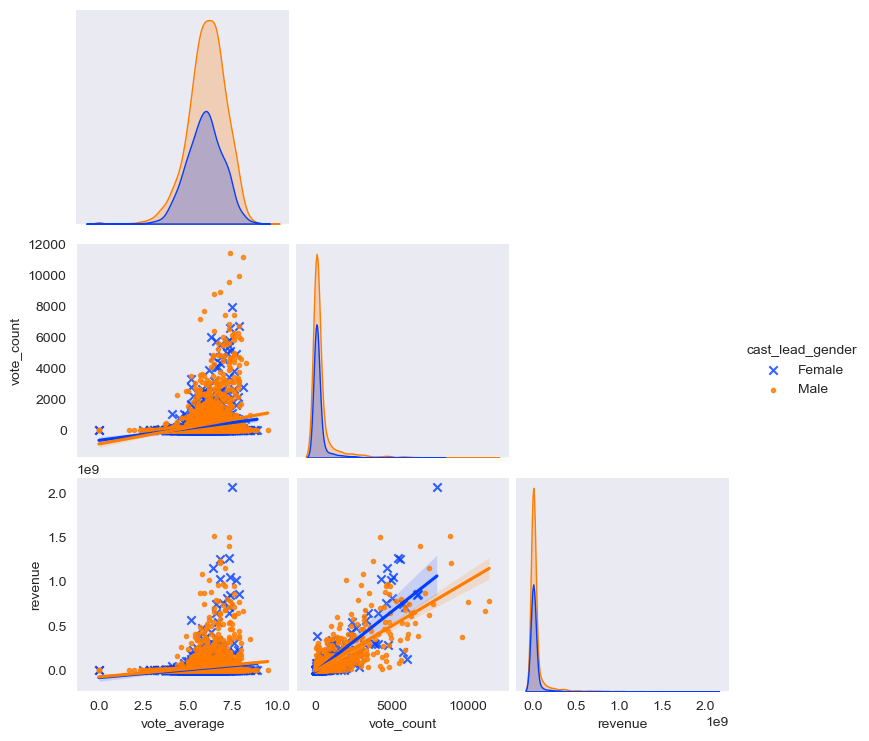

In [21]:
# min_votes of 100 -> 1315 movies, 
# min_votes of 10 -> 3767 movies
min_votes = 10
gender_rating_df = kaggle_cleaned_df.loc[kaggle_cleaned_df['vote_count'] >= min_votes,
                                         ['vote_average','vote_count','revenue','cast_lead_gender']]
print('num movies ', len(gender_rating_df))

# fig, ax = plt.subplots(figsize=(16,20))
data = gender_rating_df
sns.pairplot(kind='reg', hue='cast_lead_gender', palette='bright', data=data, markers=['x','.'], corner=True)
sns.set_style('darkgrid')
plt.show()

Movie Rating Distribution by Lead Cast Gender

num movies:  3767


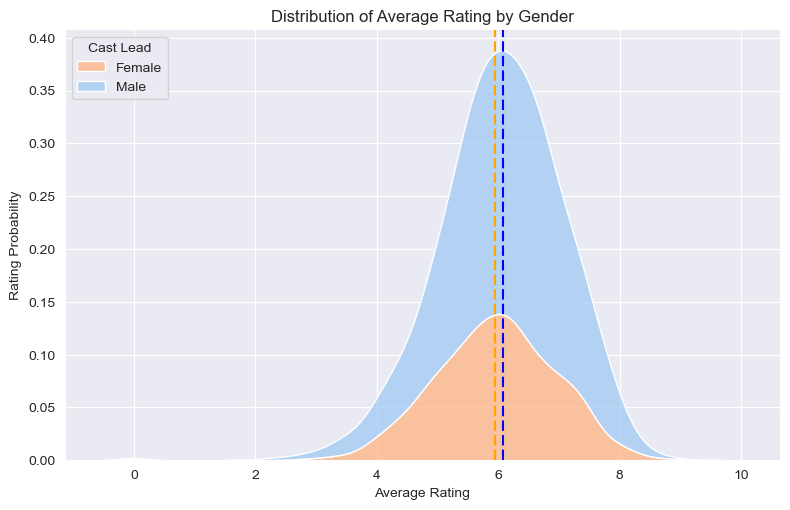

In [22]:
min_votes = 10
gender_rating_df = kaggle_cleaned_df.loc[kaggle_cleaned_df['vote_count'] >= min_votes,
                                         ['vote_average','vote_count','revenue','cast_lead_gender']]
print('num movies: ', len(gender_rating_df))


sns.set_style('darkgrid')

data = gender_rating_df
ax = sns.displot(x = 'vote_average', 
                 data=data, 
                 hue='cast_lead_gender', 
                 kind='kde', 
                 hue_order=['Male','Female'], 
                 palette='pastel', 
                 multiple='stack',
                 legend=False,
                 height=5, 
                 aspect=1.6).set(title='Distribution of Average Rating by Gender',
                                 xlabel='Average Rating',
                                 ylabel='Rating Probability')
plt.legend(title='Cast Lead', loc='upper left', labels=['Female', 'Male'])
female_mean = gender_rating_df.groupby('cast_lead_gender').mean().loc['Female', 'vote_average']
plt.axvline(female_mean,0,200, color='orange', dashes=[5,2])
male_mean = gender_rating_df.groupby('cast_lead_gender').mean().loc['Male', 'vote_average']
plt.axvline(male_mean,0,200, color='blue', dashes=[5,2])

plt.show()

Movie Profit Distribution by Lead Cast Gender

num movies:  564


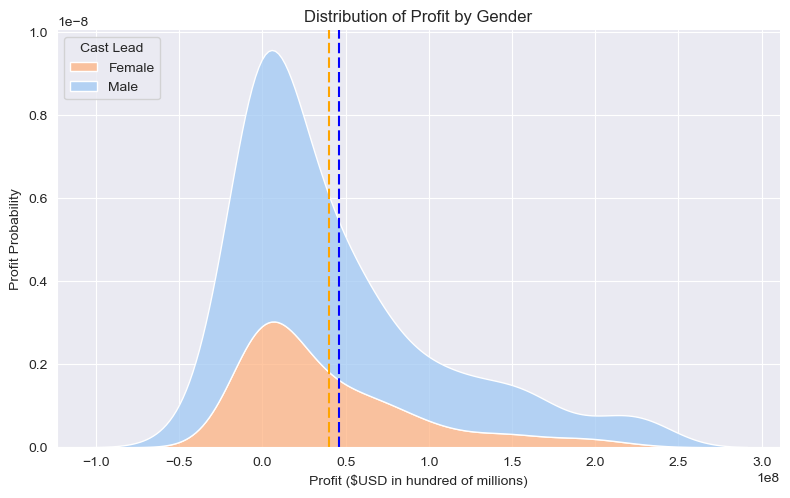

In [23]:
gender_profit_df = kaggle_cleaned_df[['title','release_date','revenue','cast_lead_gender']]
gender_profit_df = gender_profit_df.merge(modern_budgets_df[['movie','release_year','profit']],
                                          how='inner',
                                          left_on=['title','release_date'],
                                          right_on=['movie','release_year'],
                                          suffixes=['_l','_r'])
print('num movies: ', len(gender_profit_df))


sns.set_style('darkgrid')

data = gender_profit_df
column_name = 'profit'
ax = sns.displot(x = column_name, 
                 data=data, 
                 hue='cast_lead_gender', 
                 hue_order=['Male','Female'], 
                 multiple='stack',
                 palette='pastel', 
                 kind='kde', 
                 legend=False,
                 aspect=1.6).set(title='Distribution of Profit by Gender',
                                 xlabel='Profit ($USD in hundred of millions)',
                                 ylabel='Profit Probability')

plt.legend(title='Cast Lead', loc='upper left', labels=['Female', 'Male'])
female_mean = gender_profit_df.groupby('cast_lead_gender').mean().loc['Female', column_name]
plt.axvline(female_mean,0,200, color='orange', dashes=[5,2])
male_mean = gender_profit_df.groupby('cast_lead_gender').mean().loc['Male', column_name]
plt.axvline(male_mean,0,200, color='blue', dashes=[5,2])

plt.show()

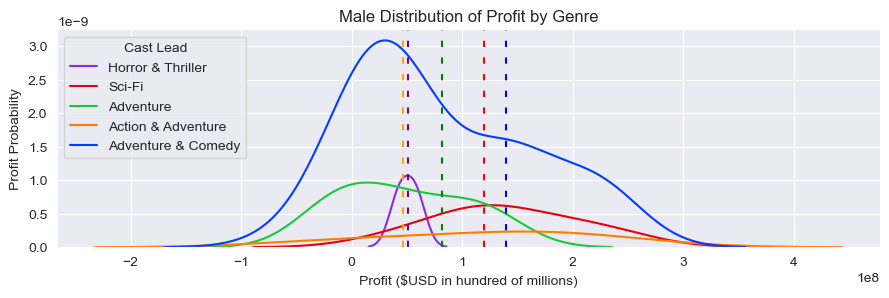

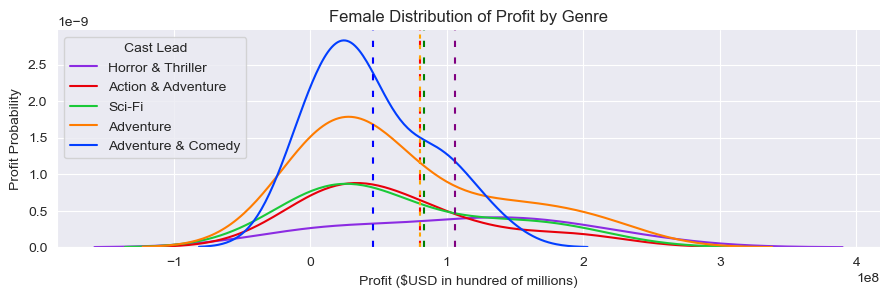

In [95]:
# gender_profit_genre_df contains -> cast lead gender, profit and genre for all films in top5 genres
# *Equal Number of male and female movies:
#   - Films with male lead actors are sampled to equal the population size of female movies
gender_profit_genre_df = kaggle_cleaned_df[['title','release_date','revenue','cast_lead_gender']]
gender_profit_genre_df = gender_profit_genre_df.merge(profit_genreTuples_df[['movie',
                                                                             'release_year',
                                                                             'profit',
                                                                             'genres']],
                                                      how='inner',
                                                      left_on=['title','release_date'],
                                                      right_on=['movie','release_year'],
                                                      suffixes=['_l','_r'])
genre_loc = gender_profit_genre_df['genres'].map(lambda x: x in top5_genre_combos)
gender_profit_genre_df = gender_profit_genre_df.loc[genre_loc]
gender_profit_genre_df['genres'] = gender_profit_genre_df['genres'].astype(str)

# sampling male lead actor movies to equal the population size of female movies
female_data = gender_profit_genre_df.loc[gender_profit_genre_df['cast_lead_gender'] == 'Female']
male_data   = gender_profit_genre_df.loc[gender_profit_genre_df['cast_lead_gender'] == 'Male']
male_data['weights'] = male_data['genres'].map(lambda x: male_data.groupby('genres').count()['title'].loc[x])
male_data_ = male_data.copy()
male_data = male_data_.sample(female_data.shape[0], weights='weights')
# repeat sample until all genres are represented
while((len(male_data['genres'].unique()) < 5) and \
      (len(male_data.loc[male_data['genres']==str(top5_genre_combos[-1])]) < 2)):
    male_data = male_data_.sample(female_data.shape[0], weights='weights')

#Set plot Style
sns.set_style('darkgrid')

# plotting Male Distribution of Profit by Genre
data = male_data
column_name = 'profit'
ax = sns.displot(x = column_name, 
                 data=data, 
                 hue='genres',
                 palette='bright', 
                 kind='kde', 
                 legend=False,
                 height=3,
                 aspect=3).set(title='Male Distribution of Profit by Genre',
                                 xlabel='Profit ($USD in hundred of millions)',
                                 ylabel='Profit Probability')

# pl = ['Adventure & Comedy','Action & Adventure','Adventure','Sci-Fi','Horror & Thriller']
pl = get_pretty_labels(top5_genre_combos)
plt.legend(title='Cast Lead', loc='upper left', labels=[pl[4],pl[3],pl[2],pl[1],pl[0]])

#plotting Male mean lines
g = male_data.groupby('genres').mean()
idx = g.index
x = g.loc[idx[0]]['profit']
plt.axvline(x,0,200, color='orange', dashes=[3,5]) #Action

x = g.loc[idx[1]]['profit']
plt.axvline(x,0,200, color='blue', dashes=[3,5]) # comedy

x = g.loc[idx[2]]['profit']
plt.axvline(x,0,200, color='purple', dashes=[3,5]) # horror

x = g.loc[idx[3]]['profit']
plt.axvline(x,0,200, color='green', dashes=[3,5]) #adventure

x = g.loc[idx[4]]['profit']
plt.axvline(x,0,200, color='red', dashes=[3,5]) #scifi


# plotting Female Distribution of Profit by Genre
data = female_data
column_name = 'profit'
sns.displot(x = column_name, 
            data=data, 
            hue='genres', 
            palette='bright', 
            kind='kde', 
            legend=False,
            height=3,
            aspect=3).set(title='Female Distribution of Profit by Genre',
                                 xlabel='Profit ($USD in hundred of millions)',
                                 ylabel='Profit Probability')

#plotting Female mean lines
g = gender_profit_genre_df.groupby('genres').mean()
idx = g.index

x = g.loc[idx[0]]['profit']
plt.axvline(x,0,200, color='red', dashes=[3,5])

x = g.loc[idx[1]]['profit']
plt.axvline(x,0,200, color='purple', dashes=[3,5])

x = g.loc[idx[2]]['profit']
plt.axvline(x,0,200, color='blue', dashes=[3,5])

x = g.loc[idx[3]]['profit']
plt.axvline(x,0,200, color='orange', dashes=[2,3])

x = g.loc[idx[4]]['profit']
plt.axvline(x,0,200, color='green', dashes=[3,5])


# ['Adventure & Comedy','Action & Adventure','Adventure','Sci-Fi','Horror & Thriller']
pl = get_pretty_labels(top5_genre_combos)
plt.legend(title='Cast Lead', loc='upper left', labels=[pl[4],pl[1],pl[3],pl[2],pl[0]])



plt.show()